### 1. Mount Google Drive
Mounts Google Drive to access the processed domain-specific datasets.

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


### 2. Initialize Qdrant Client
Initializes the connection to the Qdrant Cloud vector database using the provided URL and API key. This client will be used to create collections and upload vectors.

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest

qdrant_client = QdrantClient(
     url="Enter Your api Url****",
     api_key="Enter your Api Key**"
)


### 3. Load Embedding Model
Loads the `sentence-transformers/all-MiniLM-L6-v2` model. We verify the embedding dimension (which should be 384) to ensure it matches our vector database configuration.

In [ ]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
print(model.get_sentence_embedding_dimension())


384


### 4. Inspect Processed Data (Snippet 1)
Reads and prints the first line of the processed AI dataset (`ai.jsonl`) to verify the data format before indexing.

In [ ]:
import json

path = "/content/drive/MyDrive/OpenAlex_CS_2025_Data/processed/ai.jsonl"

with open(path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(json.loads(line))
        break


{'openalex_id': 'https://openalex.org/W2964015378', 'doi': 'https://doi.org/10.4230/lipics.ecoop.2025.6', 'title': 'Detecting Functionality-Specific Vulnerabilities via Retrieving Individual Functionality-Equivalent APIs in Open-Source Repositories', 'publication_year': 2025, 'publication_date': '2025-01-01', 'authors': [{'author_id': 'https://openalex.org/A5025691113', 'name': 'Thomas Kipf'}, {'author_id': 'https://openalex.org/A5087368991', 'name': 'Max Welling'}], 'concepts': [{'id': 'https://openalex.org/C41008148', 'name': 'Computer science'}, {'id': 'https://openalex.org/C132525143', 'name': 'Graph'}, {'id': 'https://openalex.org/C81363708', 'name': 'Convolutional neural network'}, {'id': 'https://openalex.org/C48044578', 'name': 'Scalability'}, {'id': 'https://openalex.org/C154945302', 'name': 'Artificial intelligence'}, {'id': 'https://openalex.org/C66746571', 'name': 'ENCODE'}, {'id': 'https://openalex.org/C774472', 'name': 'Margin (machine learning)'}, {'id': 'https://openale

### 6. Full Indexing Pipeline
This is the main ingestion script for the AI domain:
1.  **Config**: Sets the collection name (`cs_ai_full`), batch size, and vector size.
2.  **Setup**: Creates the Qdrant collection if it doesn't exist, using Cosine distance.
3.  **Ingest**:
    *   Reads the `ai.jsonl` file.
    *   Combines `title` and `abstract` into a single text string.
    *   Generates the 384-d embedding vector.
    *   Constructs the payload with all metadata (authors, concepts, venue, etc.).
    *   Uploads points in batches to Qdrant for efficiency.
    *   Handles the final batch and prints a success message.

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct, VectorParams, Distance
from sentence_transformers import SentenceTransformer
import json
from tqdm import tqdm

# ---------------- CONFIG ----------------
COLLECTION = "cs_ai_full"   # ✅ NEW COLLECTION
BATCH_SIZE = 64             # safer for cloud
VECTOR_SIZE = 384

# ---------------- MODEL -----------------
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# ---------------- QDRANT ----------------
client = QdrantClient(
    url="Enter Your api Url****",
    api_key="Enter your Api Key**"
    timeout=60  # ✅ IMPORTANT
)

# ---------------- COLLECTION SETUP ----------------
if not client.collection_exists(COLLECTION):
    client.create_collection(
        collection_name=COLLECTION,
        vectors_config=VectorParams(
            size=VECTOR_SIZE,
            distance=Distance.COSINE
        )
    )

# ---------------- INGEST ----------------
points = []
idx = 0

with open(
    "/content/drive/MyDrive/OpenAlex_CS_2025_Data/processed/ai.jsonl",
    "r",
    encoding="utf-8"
) as f:

    for line in tqdm(f, desc="Indexing AI Papers"):
        paper = json.loads(line)

        text = f"{paper.get('title','')} {paper.get('abstract','')}".strip()
        if len(text) < 30:
            continue

        vector = model.encode(text).tolist()

        payload = {
            "openalex_id": paper.get("openalex_id"),
            "doi": paper.get("doi"),
            "title": paper.get("title"),
            "abstract": paper.get("abstract"),
            "publication_year": paper.get("publication_year"),
            "publication_date": paper.get("publication_date"),
            "venue": paper.get("venue"),
            "citation_count": paper.get("citation_count"),
            "is_open_access": paper.get("is_open_access"),
            "oa_status": paper.get("oa_status"),
            "url": paper.get("url"),

            # 🔥 STRUCTURED FIELDS
            "authors": [
                {
                    "id": a.get("author_id"),
                    "name": a.get("name")
                } for a in paper.get("authors", [])
            ],

            "concepts": [
                {
                    "id": c.get("id"),
                    "name": c.get("name")
                } for c in paper.get("concepts", [])
            ]
        }

        points.append(
            PointStruct(
                id=idx,
                vector=vector,
                payload=payload
            )
        )
        idx += 1

        if len(points) == BATCH_SIZE:
            client.upsert(
                collection_name=COLLECTION,
                points=points,
                wait=False  # ✅ avoids timeout
            )
            points = []

# Final flush
if points:
    client.upsert(
        collection_name=COLLECTION,
        points=points,
        wait=False
    )

print("✅ FULL AI COLLECTION INDEXED SUCCESSFULLY")


Indexing AI Papers: 127537it [1:07:32, 31.47it/s]

✅ FULL AI COLLECTION INDEXED SUCCESSFULLY


### 7. Test Retrieval
Performs a sanity check on the indexed collection:
1.  Encodes a test query ("What are the open research gaps in AI security?").
2.  Searches the `cs_ai_full` collection for the top 5 nearest neighbors.
3.  Prints the detailed results, including score, metadata, abstract, authors, and concepts, to verify retrieval quality.

In [ ]:
from qdrant_client import QdrantClient
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

client = QdrantClient(
   url="Enter Your api Url****",
     api_key="Enter your Api Key**"
)

query = "What are the open research gaps in AI security?"
vector = model.encode(query).tolist()

results = client.query_points(
    collection_name="cs_ai_full" ,
    query=vector,
    limit=5,
    with_payload=True
)

print(f"Returned points: {len(results.points)}")

for i, hit in enumerate(results.points, start=1):
    p = hit.payload

    print(f"\n--- Result {i} ---")
    print("Score:", round(hit.score, 4))
    print("Title:", p.get("title"))
    print("DOI:", p.get("doi"))
    print("Year:", p.get("publication_year"))
    print("Venue:", p.get("venue"))
    print("Citations:", p.get("citation_count"))
    print("Open Access:", p.get("is_open_access"), "| Status:", p.get("oa_status"))
    print("URL:", p.get("url"))

    # ✅ SAFE abstract handling
    abstract = p.get("abstract")
    if abstract:
        print("Abstract:", abstract[:600])
    else:
        print("Abstract: ❌ Not available")

    # ✅ Authors
    authors = p.get("authors", [])
    if authors:
        print("Authors:", ", ".join(a["name"] for a in authors[:5]))
    else:
        print("Authors: ❌ Not available")

    # ✅ Concepts
    concepts = p.get("concepts", [])
    if concepts:
        print("Concepts:", ", ".join(c["name"] for c in concepts[:6]))
    else:
        print("Concepts: ❌ Not available")

Returned points: 5

--- Result 1 ---
Score: 0.5844
Title: Measuring the openness of AI foundation models: competition and policy implications
DOI: https://doi.org/10.1080/13600834.2025.2461953
Year: 2025
Venue: Information & Communications Technology Law
Citations: 3
Open Access: True | Status: hybrid
URL: https://openalex.org/W4408468248
Abstract: ❌ Not available
Authors: Thibault Schrepel, Jason Potts
Concepts: Openness to experience, Commons, Bottleneck, Competition (biology), Foundation (evidence), Artificial intelligence

--- Result 2 ---
Score: 0.57
Title: AI Mismatches: Identifying Potential Algorithmic Harms Before AI Development
DOI: https://doi.org/10.1145/3706598.3714098
Year: 2025
Venue: None
Citations: 5
Open Access: True | Status: gold
URL: https://openalex.org/W4409767074
Abstract: ❌ Not available
Authors: Devansh Saxena, Ji-Youn Jung, Jodi Forlizzi, Kenneth Holstein, John Zimmerman
Concepts: Computer science, Artificial intelligence, Development (topology), Data science

### 8. Check Collection Info
Retrieves and prints the total number of points (vectors) in the `cs_ai` collection to verify that indexing was successful.

In [ ]:
info = client.get_collection("cs_ai")
print("Points:", info.points_count)


Points: 66560


### 9. Define Test Queries
Defines a list of 20 research-grade queries related to AI (e.g., "hallucination mitigation", "federated learning privacy") to evaluate the system's performance.

In [ ]:
TEST_QUERIES = [
    "research gaps in artificial intelligence safety",
    "hallucination mitigation in large language models",
    "federated learning privacy challenges",
    "alignment problems in foundation models",
    "energy efficient deep learning architectures",
    "ethical governance of AI systems",
    "explainability in neural networks",
    "adversarial robustness in AI models",
    "AI regulation and global policy frameworks",
    "multi-modal foundation models limitations",
    "human-AI collaboration challenges",
    "benchmark leakage in AI evaluation",
    "AI bias detection methodologies",
    "continual learning catastrophic forgetting",
    "self-supervised learning future directions",
    "AI for scientific discovery gaps",
    "data-centric AI research challenges",
    "evaluation metrics for generative models",
    "AI safety in autonomous systems",
    "trustworthy AI system design"
]


### 10. Batch Evaluation
Runs the test queries against the Qdrant collection:
1.  Iterates through each query.
2.  Measures retrieval latency.
3.  Collects metrics for each result (score, year, citations, abstract availability).
4.  Saves the results to a CSV file (`ai_retrieval_results.csv`) and displays the first few rows.

In [ ]:
import pandas as pd
import time
import numpy as np

records = []

for q in TEST_QUERIES:
    start = time.time()
    vector = model.encode(q).tolist()

    res = client.query_points(
        collection_name=COLLECTION,
        query=vector,
        limit=10,
        with_payload=True
    )

    latency = time.time() - start

    for hit in res.points:
        p = hit.payload
        records.append({
            "query": q,
            "score": hit.score,
            "year": p.get("publication_year"),
            "citations": p.get("citation_count", 0),
            "has_abstract": 1 if p.get("abstract") else 0,
            "latency": latency
        })

df = pd.DataFrame(records)
df.to_csv("ai_retrieval_results.csv", index=False)
df.head()


,query,score,year,citations,has_abstract,latency
0,research gaps in artificial intelligence safety,0.720750,2025,2,0,0.148312
1,research gaps in artificial intelligence safety,0.674574,2025,6,0,0.148312
2,research gaps in artificial intelligence safety,0.669227,2025,2,0,0.148312
3,research gaps in artificial intelligence safety,0.652922,2025,7,0,0.148312
4,research gaps in artificial intelligence safety,0.646299,2025,3,0,0.148312


### 11. Plot Score Distribution
Visualizes the distribution of semantic similarity scores using a histogram. This helps understand the range of relevance scores returned by the model.

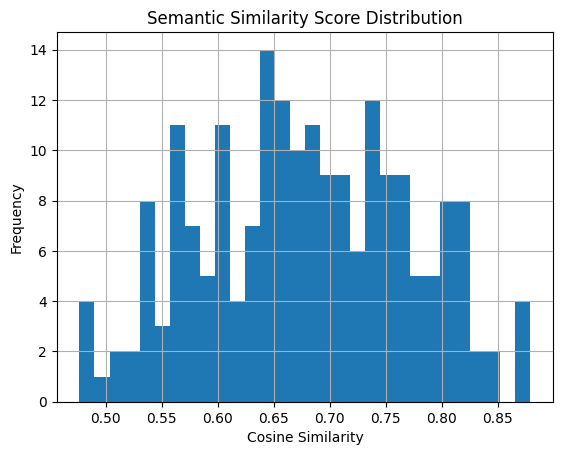

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
df["score"].hist(bins=30)
plt.title("Semantic Similarity Score Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


### 12. Plot Relevance vs. Citations
Creates a scatter plot to analyze the relationship between semantic relevance (score) and paper impact (citation count). This checks if highly relevant papers also tend to be highly cited.

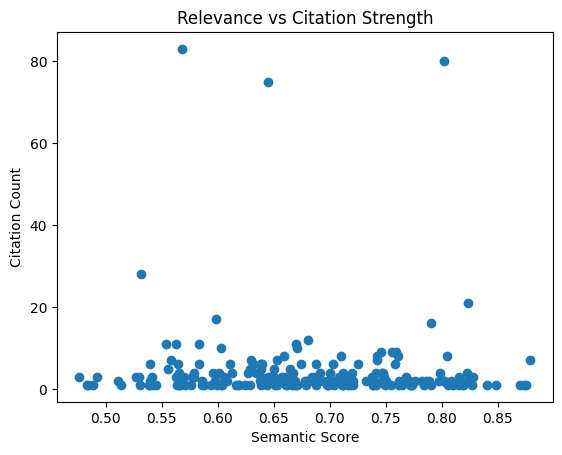

In [ ]:
plt.figure()
plt.scatter(df["score"], df["citations"])
plt.xlabel("Semantic Score")
plt.ylabel("Citation Count")
plt.title("Relevance vs Citation Strength")
plt.show()


### 13. Plot Latency
Plots the average query latency for each research question to ensure the system meets performance requirements (typically < 1 second).

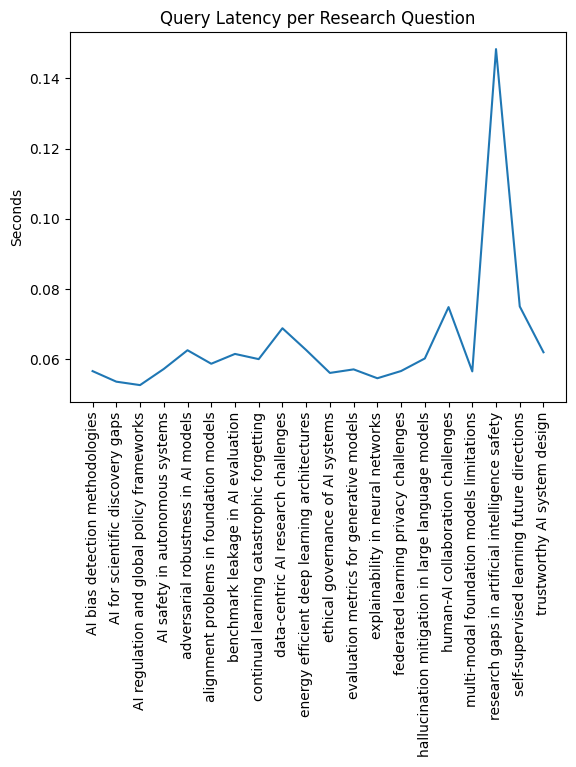

In [ ]:
plt.figure()
plt.plot(df.groupby("query")["latency"].mean())
plt.xticks(rotation=90)
plt.ylabel("Seconds")
plt.title("Query Latency per Research Question")
plt.show()
